<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

## Подготовка

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import ExtraTreesRegressor
from catboost import CatBoostRegressor, Pool
import catboost as cat
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer()
from itertools import product
from sklearn.model_selection import cross_val_score


from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace import sarimax
from statsmodels.tsa.stattools import adfuller


import seaborn as sns
import collections
sns.set(style = 'darkgrid', palette = 'Set2')

import time

import warnings
warnings.filterwarnings('ignore')

In [2]:
taxi = pd.read_csv("/datasets/taxi.csv")

In [3]:
taxi['datetime'] = pd.to_datetime(taxi['datetime'],format = '%Y-%m-%d %H:%M:%S')

In [4]:
taxi.set_index('datetime', inplace = True)
taxi.sort_index(inplace = True)
taxi.index.is_monotonic

True

In [5]:
display(taxi.head())
taxi.info()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


Переодичность в данных - 10 минут.
Ресемплируем их.

In [6]:
taxi = taxi.resample('1H').sum()

Провели обработку данных для временного ряда: перевели в Datetime из object, проверили  на монотонность, провели ресемплинг с диапозоном в 1 час, данные агрегировали с помощью суммы.

## Анализ

Text(0, 0.5, 'orders')

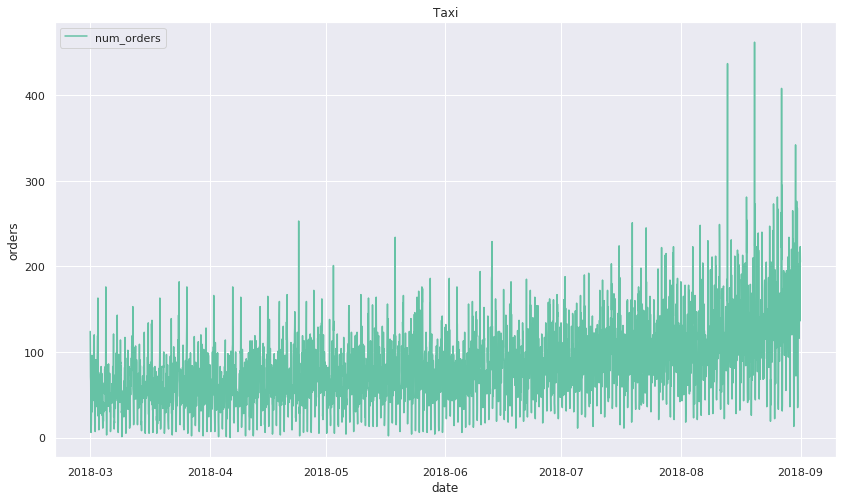

In [7]:
plt.figure(figsize=(14,8))
sns.lineplot(data=taxi)

plt.legend()
plt.title('Taxi')
plt.xlabel('date')
plt.ylabel('orders')

In [8]:
adfuller(taxi["num_orders"])

(-3.068924289027949,
 0.02894005140261345,
 30,
 4385,
 {'1%': -3.431842162413052,
  '5%': -2.8621993540813637,
  '10%': -2.567120978470452},
 41728.71357827463)

Ряд можно считать стационарным: критическое значение = -3.06 < -2.86(5-% доверительный интервал).   
Изучим тренды и сезонность.

Text(0, 0.5, 'orders')

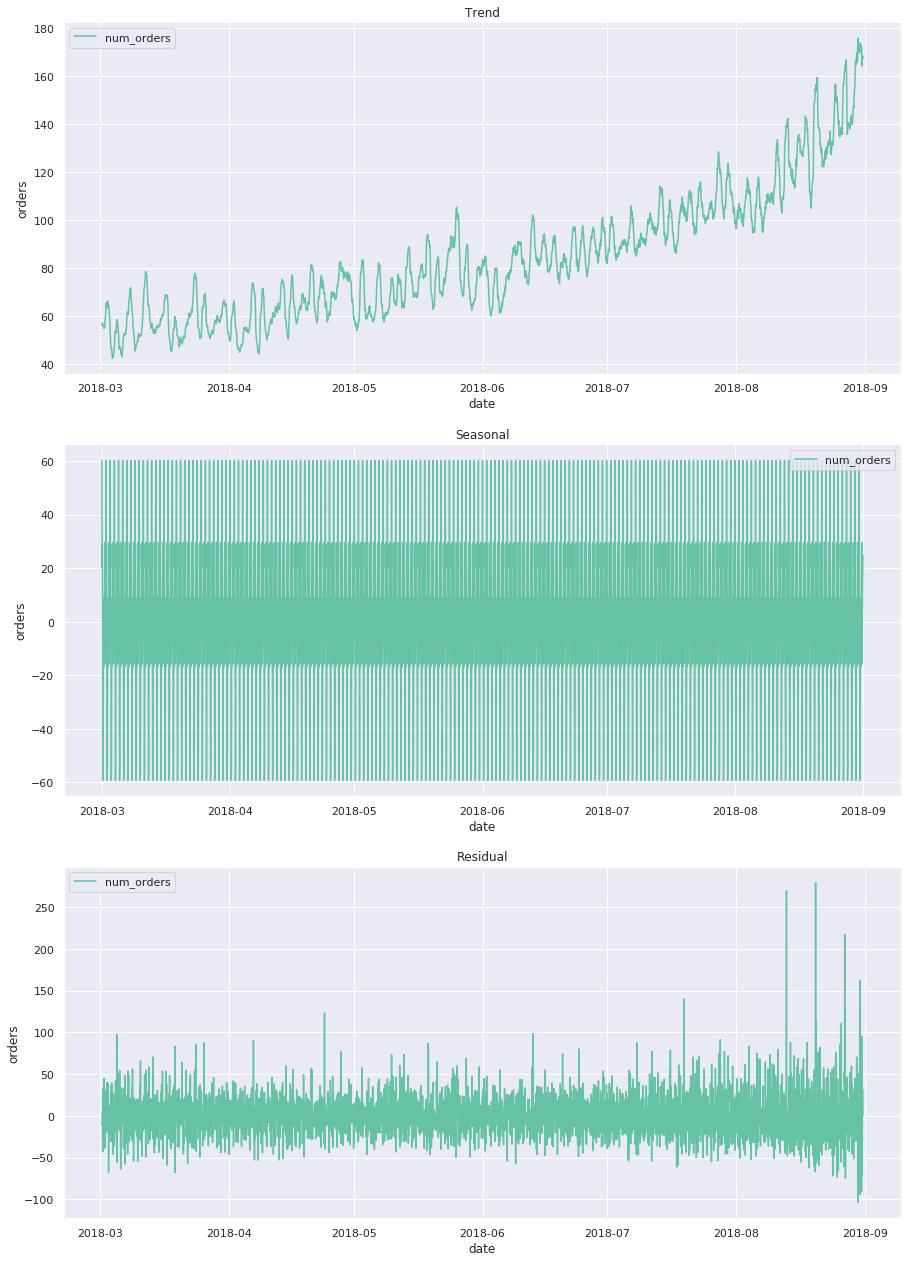

In [9]:
decomposed = seasonal_decompose(taxi)

fig, axs = plt.subplots(3, 1, figsize=(15,22))
sns.lineplot(data=decomposed.trend, ax=axs[0])
axs[0].set_title('Trend')
axs[0].set_xlabel('date')
axs[0].set_ylabel('orders')

sns.lineplot(data=decomposed.seasonal, ax=axs[1])
axs[1].set_title('Seasonal')
axs[1].set_xlabel('date')
axs[1].set_ylabel('orders')

sns.lineplot(data=decomposed.resid, ax=axs[2])
axs[2].set_title('Residual')
axs[2].set_xlabel('date')
axs[2].set_ylabel('orders')

Дополнительно рассмотрим данные за несколько различных периодов.

In [10]:
decomposedWeek = seasonal_decompose(taxi['2018-03-04':'2018-03-12'])
decomposedFewDays = seasonal_decompose(taxi['2018-03-04':'2018-03-06'])
decomposedMonth_apr = seasonal_decompose(taxi['2018-04-01':'2018-05-01'])
decomposedMonth_aug = seasonal_decompose(taxi['2018-07-31':'2018-08-31'])

Text(0, 0.5, 'orders')

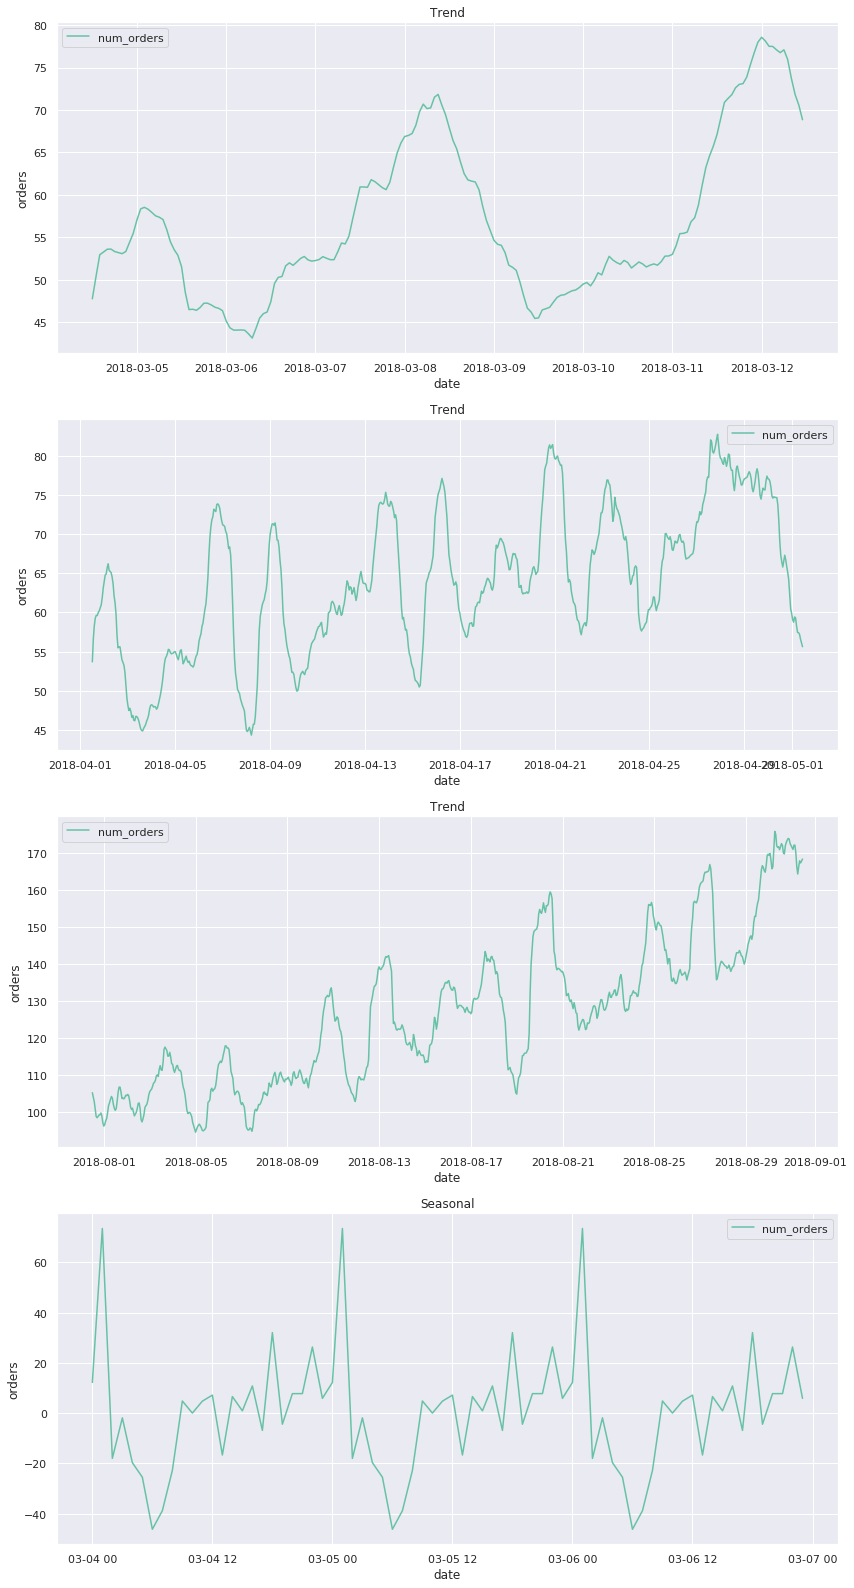

In [11]:
fig, axs = plt.subplots(4, 1, figsize=(14, 28))
sns.lineplot(data=decomposedWeek.trend, ax=axs[0])
axs[0].set_title('Trend')
axs[0].set_xlabel('date')
axs[0].set_ylabel('orders')

sns.lineplot(data=decomposedMonth_apr.trend, ax=axs[1])
axs[1].set_title('Trend')
axs[1].set_xlabel('date')
axs[1].set_ylabel('orders')


sns.lineplot(data=decomposedMonth_aug.trend, ax=axs[2])
axs[2].set_title('Trend')
axs[2].set_xlabel('date')
axs[2].set_ylabel('orders')

sns.lineplot(data=decomposedFewDays.seasonal, ax=axs[3])
axs[3].set_title('Seasonal')
axs[3].set_xlabel('date')
axs[3].set_ylabel('orders')

Тренды:
- Весь датасет: в летний период количество заказов растет.

- Неделя из датасета: 5 марта 2018 года (понедельник) - 11 марта 2018 года (воскресенье),спрос слабее во вторник, субботу и воскресенье.

- Апрель и август: ситуация схожа с днями недели. Дополнительно, к концу каждого месяца увеличивается число заказов, но летом этот рост значительнее.

Сезонность по часам: утром самые низкие показатели заказов, которые относительно нормализуются к 12, ночью наблюдаем скачок.

Text(0, 0.5, 'orders')

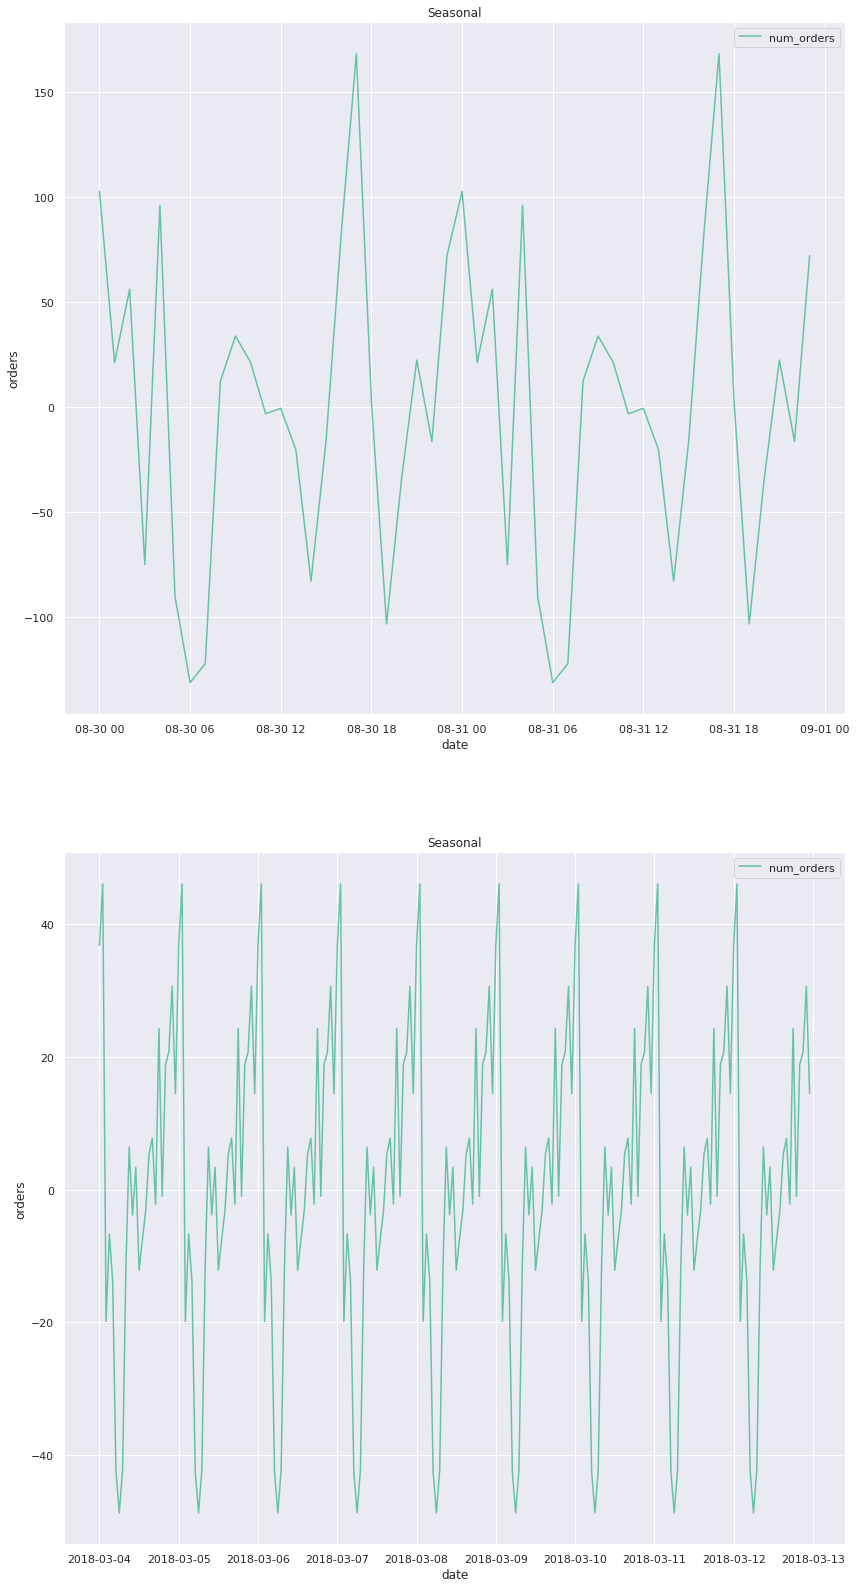

In [12]:
decomposed_taxi_24h = seasonal_decompose(taxi['2018-08-30':'2018-08-31'])

fig, axs = plt.subplots(2, 1, figsize=(14, 28))
sns.lineplot(data=decomposed_taxi_24h.seasonal, ax=axs[0])
axs[0].set_title('Seasonal')
axs[0].set_xlabel('date')
axs[0].set_ylabel('orders')

sns.lineplot(data=decomposedWeek.seasonal, ax=axs[1])
axs[1].set_title('Seasonal')
axs[1].set_xlabel('date')
axs[1].set_ylabel('orders')

Введем несколько признаков:
- day - видна ежедневная сезонность.
- dayofweek - к концу недели идет увеличение заказов.
- month- из месяца в месяц данные отличаются, но носят цикличный характер.


Нужно определить количество lag признаков, для этого попробуем найти разницу в часах между ночным пиком (max) и пиком в сезонном сегменте(min).  
Помимо этого нужно определить rolling_mean, поэтому определим, какое окно в скользяще среднем лучше всего напоминает данные.

In [13]:

decomposed_taxi_24h = seasonal_decompose(taxi['2018-08-30':'2018-08-31'])

max_lag = ((decomposed_taxi_24h.seasonal.idxmax() - decomposed_taxi_24h.seasonal.idxmin()) 
            // np.timedelta64(1, 'h'))[0]

max_lag

11

In [14]:

rolling_mean_size_dict = {}
for rolling_mean_size in range(2,49):
    data = taxi['2018-08-30':'2018-08-31']
    data['rolling_mean'] = data['num_orders'].rolling(rolling_mean_size).mean()
    data.dropna(inplace=True)
    index = data.index
    num_orders = data['num_orders']
    rolling_mean = data['rolling_mean']
    RMSE = mean_squared_error(num_orders,rolling_mean)**0.5
    rolling_mean_size_dict[rolling_mean_size] = RMSE
    
rolling_mean_size = min(rolling_mean_size_dict.keys(), key=(lambda x: rolling_mean_size_dict[x]))
rolling_mean_size

33

Теперь можно перейти к созданию признаков.

In [15]:
def make_features(data, column, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data[column].shift(lag)

    data['rolling_mean'] = data[column].shift().rolling(rolling_mean_size).mean()

In [16]:
taxi_copy = taxi.copy()
make_features(taxi,'num_orders', max_lag, rolling_mean_size)

train, test = train_test_split(taxi, shuffle=False, test_size=0.1, random_state = 1234567)
valid,test = train_test_split(test,shuffle = False, random_state = 1234567, test_size = 0.5)
train = train.dropna()

features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']
features_valid = valid.drop('num_orders', axis=1)
target_valid = valid['num_orders']

- данные проанализированы
- признаки созданы
- подготовка к обучению завершена

## Обучение

In [17]:
%%time

regressor = ExtraTreesRegressor() 
max_depth_list = [x for x in range(2, 21)]
hyperparams = [{'criterion':['mse'],
                'max_depth':max_depth_list, 
                'n_estimators':[x for x in range(100, 301, 50)],
                'random_state':[1234567]}]

ETR_grid = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
ETR_grid.fit(features_train, target_train)

CPU times: user 5min 20s, sys: 1 s, total: 5min 21s
Wall time: 5min 22s


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=ExtraTreesRegressor(bootstrap=False, criterion='mse',
                                           max_depth=None, max_features='auto',
                                           max_leaf_nodes=None,
                                           min_impurity_decrease=0.0,
                                           min_impurity_split=None,
                                           min_samples_leaf=1,
                                           min_samples_split=2,
                                           min_weight_fraction_leaf=0.0,
                                           n_estimators='warn', n_jobs=None,
                                           oob_score=False, random_state=None,
                                           verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'criterion': ['mse'],
                          'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 1

**CatBoost**

In [18]:
splits = TimeSeriesSplit(n_splits=8)

In [19]:
catboost = CatBoostRegressor(loss_function='RMSE', random_state = 1234567)
parameters_cat = {'depth':[5,10], 'learning_rate':np.arange(0.1,1,0.2)}
catboost_grid = catboost.grid_search(parameters_cat,
                    Pool(features_train, target_train),cv=splits,verbose=True)

0:	loss: 32.6622282	best: 32.6622282 (0)	total: 20.2s	remaining: 3m 2s
1:	loss: 32.1078922	best: 32.1078922 (1)	total: 35s	remaining: 2m 20s
2:	loss: 31.8931993	best: 31.8931993 (2)	total: 51s	remaining: 1m 58s
3:	loss: 33.0281926	best: 31.8931993 (2)	total: 1m 6s	remaining: 1m 39s
4:	loss: 34.6793070	best: 31.8931993 (2)	total: 1m 21s	remaining: 1m 21s
5:	loss: 38.4451737	best: 31.8931993 (2)	total: 2m 58s	remaining: 1m 58s
6:	loss: 37.4729006	best: 31.8931993 (2)	total: 4m 34s	remaining: 1m 57s
7:	loss: 37.3344208	best: 31.8931993 (2)	total: 6m 11s	remaining: 1m 32s
8:	loss: 38.2262408	best: 31.8931993 (2)	total: 7m 47s	remaining: 52s
9:	loss: 39.9944753	best: 31.8931993 (2)	total: 9m 24s	remaining: 0us
Estimating final quality...


In [20]:
%%time
final_cat = CatBoostRegressor(depth=catboost_grid["params"]["depth"], 
                              learning_rate=catboost_grid["params"]['learning_rate'],
                              loss_function='RMSE',verbose=100)
final_cat.fit(Pool(features_train, target_train))

0:	learn: 31.5998130	total: 3.54ms	remaining: 3.54s
100:	learn: 14.9855076	total: 1.63s	remaining: 14.5s
200:	learn: 11.1704618	total: 3.38s	remaining: 13.4s
300:	learn: 8.6781251	total: 5.04s	remaining: 11.7s
400:	learn: 6.8914128	total: 6.71s	remaining: 10s
500:	learn: 5.4835197	total: 8.47s	remaining: 8.43s
600:	learn: 4.4036048	total: 10.1s	remaining: 6.72s
700:	learn: 3.4634953	total: 12s	remaining: 5.11s
800:	learn: 2.7935405	total: 13.7s	remaining: 3.42s
900:	learn: 2.2600807	total: 15.4s	remaining: 1.69s
999:	learn: 1.8164783	total: 17.2s	remaining: 0us
CPU times: user 15.1 s, sys: 2.5 s, total: 17.6 s
Wall time: 18.7 s


**LightGBM**

In [21]:
%%time

lgb_train = lgb.Dataset(features_train, target_train)
lgb_valid = lgb.Dataset(features_valid, target_valid, reference=lgb_train)
parameters_light = {'metric': 'l2', 'max_depth':10,"random_state": 1234567,"learning_rate":0.1}
light = lgb.train(parameters_light,
                lgb_train,
                num_boost_round=1000,
                valid_sets=[lgb_train,lgb_valid],
                verbose_eval=100)

[100]	training's l2: 201.416	valid_1's l2: 1397.66
[200]	training's l2: 116.189	valid_1's l2: 1372.98
[300]	training's l2: 70.9356	valid_1's l2: 1364.92
[400]	training's l2: 43.5572	valid_1's l2: 1368.47
[500]	training's l2: 28.2641	valid_1's l2: 1369.61
[600]	training's l2: 18.2637	valid_1's l2: 1369.14
[700]	training's l2: 11.8077	valid_1's l2: 1371.75
[800]	training's l2: 7.94673	valid_1's l2: 1381.12
[900]	training's l2: 5.56391	valid_1's l2: 1378.4
[1000]	training's l2: 3.61175	valid_1's l2: 1376.58
CPU times: user 16.9 s, sys: 227 ms, total: 17.1 s
Wall time: 17.3 s


## Тестирование

In [22]:
    # ExtraTreesRegressor
    
# Valid
preds_ETR_valid = ETR_grid.best_estimator_.predict(features_valid)

# Test
ETR_test_start_time = time.time()
preds_ETR_test = ETR_grid.best_estimator_.predict(features_test)
ETR_test_total_time = time.time() - ETR_test_start_time

# Train
preds_ETR_train = ETR_grid.best_estimator_.predict(features_train)

In [23]:
    # CatBoost
    
# Valid
preds_Cat_valid = final_cat.predict(features_valid)

# Test
CatBoost_test_start_time = time.time()
preds_Cat_test = final_cat.predict(features_test)
CatBoost_test_total_time = time.time() - CatBoost_test_start_time

# Train
preds_Cat_train = final_cat.predict(features_train)

In [24]:
   #LightGBM

# Valid
preds_Light_valid = light.predict(features_valid)
 
# Test
LightGBM_test_start_time = time.time()
preds_Light_test = light.predict(features_test)
LightGBM_test_total_time = time.time() - LightGBM_test_start_time

# Train
preds_Light_train = light.predict(features_train)

In [25]:
#Train
    # ExtraTreesRegressor
RMSE_ETR_train = (mean_squared_error(target_train, preds_ETR_train))**0.5
    # CatBoost
RMSE_CatBoost_train = (mean_squared_error(target_train, preds_Cat_train))**0.5
    #LightGBM
RMSE_LightGBM_train = (mean_squared_error(target_train, preds_Light_train))**0.5

# Valid
    # ExtraTreesRegressor
RMSE_ETR_valid = (mean_squared_error(target_valid, preds_ETR_valid))**0.5
    # CatBoost
RMSE_CatBoost_valid = (mean_squared_error(target_valid, preds_Cat_valid))**0.5
    #LightGBM
RMSE_LightGBM_valid = (mean_squared_error(target_valid, preds_Light_valid))**0.5

# Test
    # ExtraTreesRegressor
RMSE_ETR_test = (mean_squared_error(target_test, preds_ETR_test))**0.5
    # CatBoost
RMSE_CatBoost_test = (mean_squared_error(target_test, preds_Cat_test))**0.5
    #LightGBM
RMSE_LightGBM_test = (mean_squared_error(target_test, preds_Light_test))**0.5

In [26]:
report = pd.DataFrame(columns = ["ExtraTrees", "CatBoost", "LightGBM"],
                      index = ["RMSE(train)",
                               "RMSE(valid)",
                               "RMSE(test)",
                               "Время обучения, сек",
                               "Время предсказания, сек"])


report.iloc[0] = [RMSE_ETR_train, RMSE_CatBoost_train, RMSE_LightGBM_train]
report.iloc[1] = [RMSE_ETR_valid, RMSE_CatBoost_valid, RMSE_LightGBM_valid]
report.iloc[2] = [RMSE_ETR_test, RMSE_CatBoost_test, RMSE_LightGBM_test]
report.iloc[3] = [5.2,1.62,1.44]
report.iloc[4] = [ETR_test_total_time, CatBoost_test_total_time, LightGBM_test_total_time]

In [27]:
display(report)

,ExtraTrees,CatBoost,LightGBM
RMSE(train),4.03186,1.81648,1.90046
RMSE(valid),36.5902,37.6331,37.1023
RMSE(test),50.5614,51.4217,46.0609
"Время обучения, сек",5.2,1.62,1.44
"Время предсказания, сек",0.0383027,0.00350332,0.0135539


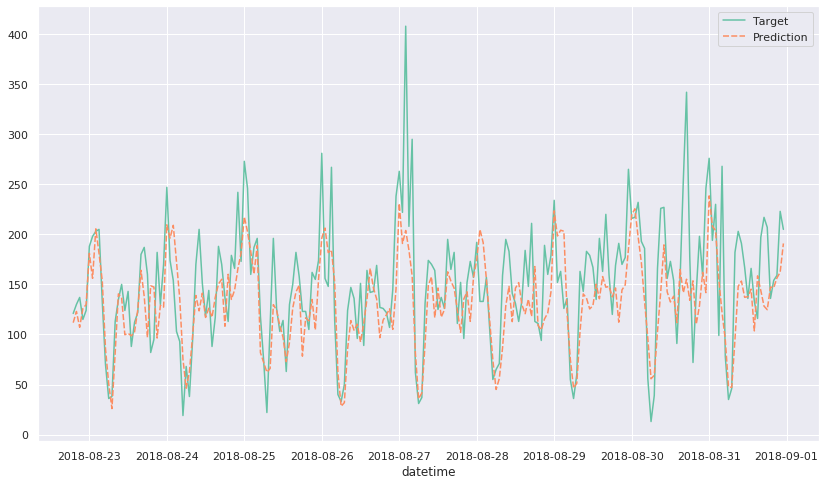

In [28]:
frame = {'Target':target_test, 'Prediction':preds_Light_test}
result = pd.DataFrame(frame)

plt.figure(figsize=(14,8))
sns.lineplot(data=result);

Обучены три различные модели:**ExtraTrees**, **CatBoost**, **LGBM**.  
Единственной моделью, которая выполнила условие (RMSE на тестовой выборке должно быть не больше 48), стала **LGBM**. Значение RMSE для нее составило 45.9573, дополнительно стоит отметить, что время обучения у этой модели наименьшее.